# Single-cell tutorial: load processed DARLIN data and lineage calling (Fig. 4)

Here, given the output from snakemake_DARLIN, which converts fastq files to individual alleles associated with each cell, we identify the rare alleles as well asa collection of cells belonging to the same clone.

You need to install mosaiclineage for running this pipeline: https://github.com/ShouWenWang-Lab/MosaicLineage

In [1]:
import cospar as cs
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import mosaiclineage as mosaic
import mosaiclineage.help_functions as hf

import importlib
importlib.reload(hf)
%matplotlib inline

## setting cospar
cs.logging.print_version()
cs.settings.verbosity=0
cs.settings.set_figure_params(format='pdf',figsize=[4,3.5],dpi=75,fontsize=14,pointsize=2)

## notebook specific parameters
target_sample='data',
read_cutoff=3  # Read cutoff: each UMI must be covered by at least 3 reads
min_clone_size=2  # Clone size cutoff: only clones with at least 2 UMI will be used in downstream analysis
frequency_cutoff=2*10**(-5) # Allele probability cutoff: the allele generation probability must be lower than this value
max_rep_N=1 # Mouse replicate number cutoff: this allele can appear in less than max_rep_N mouse samples in our allele bank

## setup folders 
root_path='../data'
ref_dir=mosaic.settings.ref_dir # allele bank reference, located within the MosalicLineage repository

if os.path.exists(root_path):
    data_path_0=os.path.join(root_path,'analysis','data')
    figure_path_0=os.path.join(root_path,'analysis','figure')
    os.makedirs(data_path_0,exist_ok=True)
    os.makedirs(figure_path_0,exist_ok=True)
    cs.settings.data_path=data_path_0
    cs.settings.figure_path=figure_path_0

/pub/kstachel/.conda/envs/darlin/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Running cospar 0.4.1 (python 3.11.14) on 2026-02-13 13:24.


# Load and analyze alleles per locus (same for bulk and single cell)

## CA

Load the allele frequency reference

Invalid fraction at specified cutoffs 0.07655872924395779


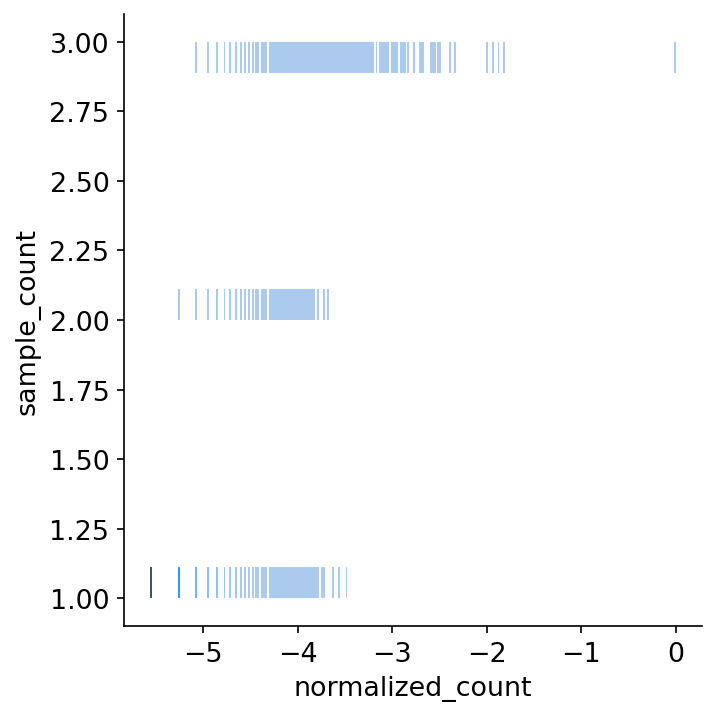

In [3]:
locus='CA'

df_ref=pd.read_csv(f'{ref_dir}/reference_merged_alleles_{locus}_Gr.csv').filter(["allele","normalized_count",'sample_count'])
sns.displot(x=np.log10(df_ref['normalized_count']),y=df_ref['sample_count'],kind='hist')
df_ref['invalid_alleles']=(df_ref['sample_count']>max_rep_N) | (df_ref['normalized_count']>frequency_cutoff)
print("Invalid fraction at specified cutoffs",np.mean(df_ref['invalid_alleles']))

In [4]:
# Prepare the data path
data_path=os.path.join(root_path,'DARLIN',f'results_cutoff_override_{read_cutoff}')

# Prepare sample list
SampleList_RAW=['SRR23027762','SRR23027765','SRR23027768','SRR23027771','SRR23027774']
short_names=SampleList_RAW

In [5]:
## extract the allele table
df_all = mosaic.DARLIN.extract_CARLIN_info(
    data_path, SampleList_RAW, sample_name_format=None # use sample_name_format=None will keep the original sample name
)
df_all = df_all.merge(df_ref, on="allele", how="left") # intersect with the allele frequency reference
df_all.head(10)

,allele,UMI_count,sample,mouse,CB,CB_N,CARLIN,CARLIN_length,clone_size,normalized_count,sample_count,invalid_alleles
0,[],321,SRR23027762,SRR23027762,"AAAGGATAGTTGTACC,AAAGTGATCCCTTGGT,AACCATGTCCGA...",321,CGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGC...,276,1683,1.000000,3.0,True
1,22_23insTA,235,SRR23027762,SRR23027762,"AAAGGATGTACAGCGA,AAAGGATGTGTGCTTA,AAAGTGACACTT...",235,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,278,1331,0.000008,1.0,False
2,157_158insG,8,SRR23027762,SRR23027762,"AAAGAACAGGGTAATT,CACTGAAGTTGTGCCG,CATGAGTTCCGA...",8,CGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGC...,277,15,0.000216,3.0,True
3,"22_23insTA,76_77insG",8,SRR23027762,SRR23027762,"CTCACTGCAACCGTGC,GAGACTTGTTCGGCCA,TAACTTCGTCGT...",8,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,279,38,0.000003,1.0,False
4,"22_23insTA,76_77insGG",8,SRR23027762,SRR23027762,"AAGACAACATTGCTGA,AGTCTCCAGACTAAGT,CACAGGCGTTGG...",8,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,280,21,0.000003,1.0,False
5,211_212insA,7,SRR23027762,SRR23027762,"AGCATCAAGCACGGAT,ATTCCCGCATACTGAC,CGTGTCTTCGAT...",7,CGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGC...,277,22,0.000180,3.0,True
6,265_266insA,7,SRR23027762,SRR23027762,"AGCCAATAGGCGCTCT,CTCCCAACAGTCAGTT,GGTTAACGTCTA...",7,CGCCGGACTGCACGACAGTCGACGATGGAGTCGACACGACTCGCGC...,277,25,0.000513,3.0,True
7,"22_23insTA,103_104insA",7,SRR23027762,SRR23027762,"AGCTACATCCCGAGAC,CACAACATCGGAAGGT,CCACGTTGTGAC...",7,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,279,13,NaN,NaN,NaN
8,"22_23insTA,211_212insA",7,SRR23027762,SRR23027762,"ACCTACCGTTCAGGTT,AGCGTCGGTATTTCGG,CATGGATGTACT...",7,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,279,27,NaN,NaN,NaN
9,"22_23insTA,265_266insAG",7,SRR23027762,SRR23027762,"AAACGCTGTCCACAGC,CCGTAGGGTACGCTAT,CCTCCTCCAATT...",7,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,280,24,NaN,NaN,NaN


In [6]:
## clean up the allele table with clone_size cutoff and allele_freqeuncy cutoff
min_clone_size=1 # exclude clones with only one cell barcode or UMI. This is optional
df_HQ = df_all.query("invalid_alleles!=True")
df_HQ = df_HQ[df_HQ["clone_size"] >= min_clone_size]

print("Allele number before correction: {}; after correction: {}".format(len(set(df_all["allele"])),len(set(df_HQ["allele"]))))

Allele number before correction: 1481; after correction: 1246


In [7]:
df_HQ.head(10)

,allele,UMI_count,sample,mouse,CB,CB_N,CARLIN,CARLIN_length,clone_size,normalized_count,sample_count,invalid_alleles
1,22_23insTA,235,SRR23027762,SRR23027762,"AAAGGATGTACAGCGA,AAAGGATGTGTGCTTA,AAAGTGACACTT...",235,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,278,1331,0.000008,1.0,False
3,"22_23insTA,76_77insG",8,SRR23027762,SRR23027762,"CTCACTGCAACCGTGC,GAGACTTGTTCGGCCA,TAACTTCGTCGT...",8,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,279,38,0.000003,1.0,False
4,"22_23insTA,76_77insGG",8,SRR23027762,SRR23027762,"AAGACAACATTGCTGA,AGTCTCCAGACTAAGT,CACAGGCGTTGG...",8,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,280,21,0.000003,1.0,False
7,"22_23insTA,103_104insA",7,SRR23027762,SRR23027762,"AGCTACATCCCGAGAC,CACAACATCGGAAGGT,CCACGTTGTGAC...",7,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,279,13,NaN,NaN,NaN
8,"22_23insTA,211_212insA",7,SRR23027762,SRR23027762,"ACCTACCGTTCAGGTT,AGCGTCGGTATTTCGG,CATGGATGTACT...",7,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,279,27,NaN,NaN,NaN
9,"22_23insTA,265_266insAG",7,SRR23027762,SRR23027762,"AAACGCTGTCCACAGC,CCGTAGGGTACGCTAT,CCTCCTCCAATT...",7,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,280,24,NaN,NaN,NaN
12,"22_23insTA,76_77insA",6,SRR23027762,SRR23027762,"ACAGCCGGTAACGTTC,ATTCAGGGTTAGGGAC,CCTATCGTCCCG...",6,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,279,28,NaN,NaN,NaN
14,"22_23insTA,103_104insT,238_239insC,265_266insG",6,SRR23027762,SRR23027762,"ATCTCTAGTTCAACGT,CAACAACCAAGACCGA,CCAATGAGTTGG...",6,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,281,7,NaN,NaN,NaN
15,"22_23insTA,66_253del",6,SRR23027762,SRR23027762,"AGGTCATCACATGTTG,CATGGTAGTGCGTTTA,GAGTGTTCACCC...",6,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,90,6,NaN,NaN,NaN
16,"22_23insTA,49_50insG",6,SRR23027762,SRR23027762,"ACAGCCGCACCCTAAA,AGTCATGCACTTTATC,ATAGGCTGTAGC...",6,CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACTCGC...,279,33,NaN,NaN,NaN


In [ ]:
# expand each CB entry so that each line corresonds to one cell, and make it to be a single-cell table
df_sc_data = mosaic.DARLIN.generate_sc_CARLIN_from_CARLIN_output(
    df_HQ, sample_name_format=None,
)

In [75]:
df_sc_data.head(10)

,allele,UMI_count,sample,mouse,cell_bc,CB_N,clone_id,CARLIN_length,clone_size,normalized_count,sample_count,invalid_alleles,locus,library,plate_ID,RNA_id,lineage
0,locus_22_23insTA,240,LL837-LF,LL837,AAAGGATGTACAGCGA,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AAAGGATGTACAGCGA,LL837-LF
1,locus_22_23insTA,240,LL837-LF,LL837,AAAGGATGTGTGCTTA,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AAAGGATGTGTGCTTA,LL837-LF
2,locus_22_23insTA,240,LL837-LF,LL837,AAAGTGACACTTGTCC,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AAAGTGACACTTGTCC,LL837-LF
3,locus_22_23insTA,240,LL837-LF,LL837,AACAAAGGTAGGCAGT,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AACAAAGGTAGGCAGT,LL837-LF
4,locus_22_23insTA,240,LL837-LF,LL837,AACCATGTCACTACGA,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AACCATGTCACTACGA,LL837-LF
5,locus_22_23insTA,240,LL837-LF,LL837,AACGGGAAGTAAACGT,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AACGGGAAGTAAACGT,LL837-LF
6,locus_22_23insTA,240,LL837-LF,LL837,AACTTCTCAAGACTGG,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AACTTCTCAAGACTGG,LL837-LF
7,locus_22_23insTA,240,LL837-LF,LL837,AAGTCGTAGGTGTGAC,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AAGTCGTAGGTGTGAC,LL837-LF
8,locus_22_23insTA,240,LL837-LF,LL837,AAGTGAAAGTTTGGCT,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AAGTGAAAGTTTGGCT,LL837-LF
9,locus_22_23insTA,240,LL837-LF,LL837,AATCGTGGTTCTAAGC,240,locus_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACG...,278,240,0.000008,1.0,False,locus,LL837-LF,LL837-LF,LL837-LF_RNA_AATCGTGGTTCTAAGC,LL837-LF


In [76]:
## generate a cell-by-allele adata at selected clone_size cutoff
adata = mosaic.lineage.generate_adata_cell_by_allele(
    df_sc_data, min_clone_size=2, clone_id_key="clone_id"
)
adata

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3835/3835 [00:00<00:00, 432943.66it/s]


AnnData object with n_obs × n_vars = 3835 × 382
    obs: 'state_info', 'time_info'
    uns: 'data_des', 'normalized_count'
    obsm: 'X_clone'

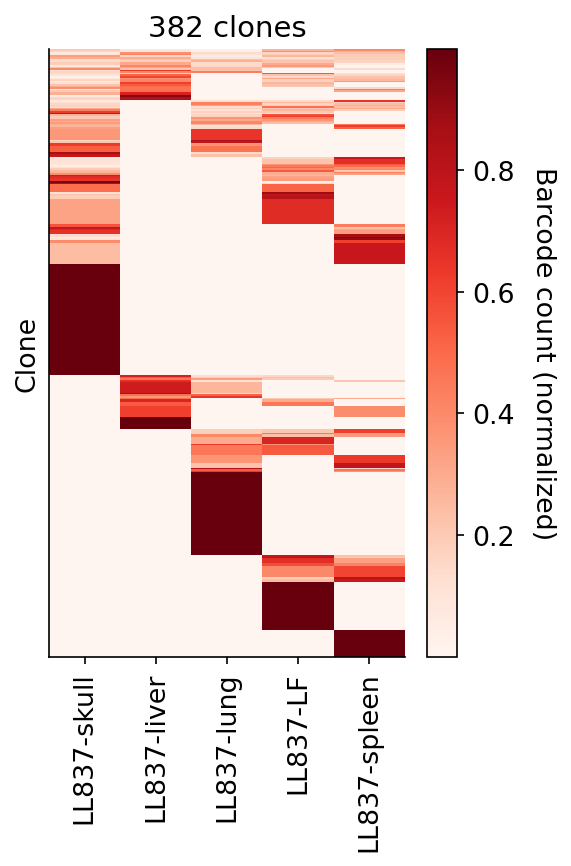

In [77]:
selected_fates=adata.obs['state_info'].unique()
cs.pl.barcode_heatmap(adata,selected_fates=selected_fates,normalize=True)
plt.ylabel('Clone')
plt.tight_layout()
plt.savefig(f'{figure_path_0}/all_clone_heatmap.pdf')

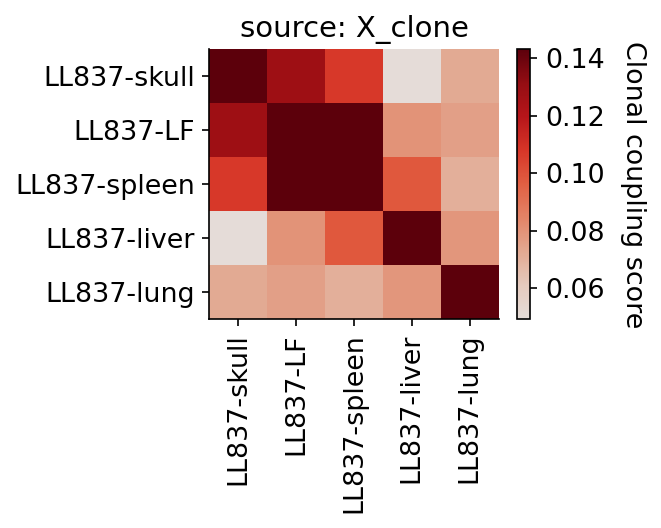

In [78]:
selected_fates=adata.obs['state_info'].unique()
cs.tl.fate_coupling(adata,selected_fates=selected_fates,source='X_clone')
cs.pl.fate_coupling(adata,source='X_clone')
plt.savefig(f'{figure_path_0}/all_clone_coupling.pdf')

In [79]:
del adata.uns
adata.write_h5ad(f'{data_path}/merge_all/sample_by_allele_adata.h5ad')
df_all.to_csv(f'{data_path}/merge_all/df_allele_all.csv',index=0)

## TA

Load the allele frequency reference

In [66]:
locus='TA'

df_ref=pd.read_csv(f'{ref_dir}/reference_merged_alleles_{locus}_Gr.csv').filter(["allele","normalized_count",'sample_count'])
#sns.displot(x=np.log10(df_ref['normalized_count']),y=df_ref['sample_count'],kind='hist')
df_ref['invalid_alleles']=(df_ref['sample_count']>max_rep_N) | (df_ref['normalized_count']>frequency_cutoff)
print("Invalid fraction at specified cutoffs",np.mean(df_ref['invalid_alleles']))

Invalid fraction at specified cutoffs 0.05831675543861901


In [ ]:
# Prepare the data path
data_path=os.path.join(root_path,'DARLIN',f'results_cutoff_override_{read_cutoff}')

# Prepare sample list
SampleList_RAW=['SRR23027764','SRR23027767','SRR23027770','SRR23027773','SRR23027776']
short_names=SampleList_RAW

In [ ]:
## extract the allele table
df_all = mosaic.DARLIN.extract_CARLIN_info(
    data_path, SampleList_RAW, sample_name_format=None # use sample_name_format=None will keep the original sample name
)
df_all = df_all.merge(df_ref, on="allele", how="left") # intersect with the allele frequency reference
df_all.to_csv(f'{data_path}/merge_all/df_allele_all.csv',index=0)

## RA

Load the allele frequency reference

In [63]:
locus='RA'

df_ref=pd.read_csv(f'{ref_dir}/reference_merged_alleles_{locus}_Gr.csv').filter(["allele","normalized_count",'sample_count'])
#sns.displot(x=np.log10(df_ref['normalized_count']),y=df_ref['sample_count'],kind='hist')
df_ref['invalid_alleles']=(df_ref['sample_count']>max_rep_N) | (df_ref['normalized_count']>frequency_cutoff)
print("Invalid fraction at specified cutoffs",np.mean(df_ref['invalid_alleles']))

Invalid fraction at specified cutoffs 0.10168935542069871


In [ ]:
# Prepare the data path
data_path=os.path.join(root_path,'DARLIN',f'results_cutoff_override_{read_cutoff}')

# Prepare sample list
SampleList_RAW=['SRR23027763','SRR23027766','SRR23027769','SRR23027772','SRR23027775']
short_names=SampleList_RAW

In [ ]:
## extract the allele table
df_all = mosaic.DARLIN.extract_CARLIN_info(
    data_path, SampleList_RAW, sample_name_format=None # use sample_name_format=None will keep the original sample name
)
df_all = df_all.merge(df_ref, on="allele", how="left") # intersect with the allele frequency reference
df_all.to_csv(f'{data_path}/merge_all/df_allele_all.csv',index=0)

# Call clones by integrating alleles from three locus

## Prepare single-cell allele data across loci

In [ ]:
data_path_CA=os.path.join(root_path,'DARLIN',f'results_cutoff_override_{read_cutoff}')
df_all_CA=pd.read_csv(f'{data_path_CA}/merge_all/df_allele_all.csv')

data_path_TA=os.path.join(root_path,'DARLIN',f'results_cutoff_override_{read_cutoff}')
df_all_TA=pd.read_csv(f'{data_path_TA}/merge_all/df_allele_all.csv')

data_path_RA=os.path.join(root_path,'DARLIN',f'results_cutoff_override_{read_cutoff}')
df_all_RA=pd.read_csv(f'{data_path_RA}/merge_all/df_allele_all.csv')

df_all_CA['locus']='CA'
df_all_TA['locus']='TA'
df_all_RA['locus']='RA'
df_merge=pd.concat([df_all_CA,df_all_TA,df_all_RA])
df_sc_data=hf.generate_sc_CARLIN_from_CARLIN_output(df_merge)

In [36]:
df_sc_data_HQ=df_sc_data[(df_sc_data['normalized_count']<frequency_cutoff) & (df_sc_data['sample_count']<(max_rep_N+1))]
len(df_sc_data_HQ)/len(df_sc_data)

0.5021688635155178

In [37]:
len(df_sc_data_HQ[df_sc_data_HQ['sample_count']==max_rep_N])/len(df_sc_data_HQ)

0.1479603209986625

In [38]:
df_sc_data.filter(['allele','cell_bc','normalized_count',	'sample_count',	'invalid_alleles'])

,allele,cell_bc,normalized_count,sample_count,invalid_alleles
0,CA_[],AAAGGATAGTTGTACC,1.0,3.0,True
1,CA_[],AAAGTGATCCCTTGGT,1.0,3.0,True
2,CA_[],AACCATGTCCGATAGT,1.0,3.0,True
3,CA_[],AACCCAACACTCGATA,1.0,3.0,True
4,CA_[],AAGACAACATTAGGAA,1.0,3.0,True
...,...,...,...,...,...
35728,"RA_23_24insT,46G>A",CCTCCAATCCCTCGTA,0.0,0.0,0
35729,"RA_23_24insT,77_78insAAGAAAAA,132_132del,158_1...",CTTTCGGGTATTGACC,0.0,0.0,0
35730,RA_23A>G,CCACAAACACTAAACC,0.0,0.0,0
35731,"RA_16_25del,266_267insA",TATCTTGCAGGCCTGT,0.0,0.0,0


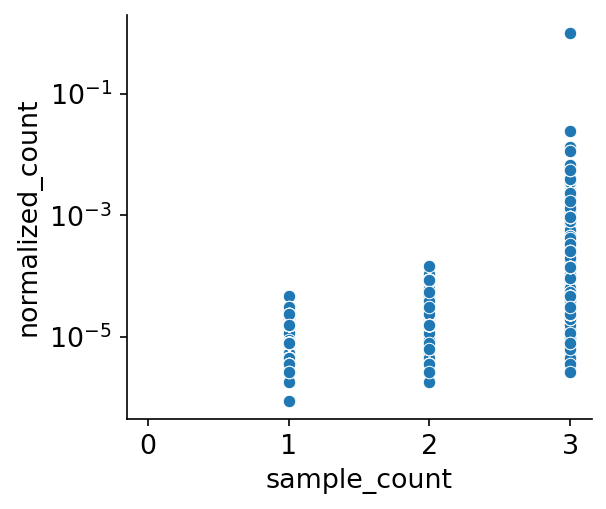

In [39]:
sns.scatterplot(data=df_sc_data,x='sample_count',y='normalized_count')
plt.yscale('log')

## Merge alleles detected in a single cell

	We also integrated alleles detected in single cells across CA, TA, and RA loci to determine which cells belonged to which clones. To do this, we constructed a graph in which each node represents a cell, with vertices connecting pairs of cells that share an allele (from CA, TA, or RA) with generation probability ρ<ρ_*. This procedure yielded a graph composed of many isolated subgraphs, with each subgraph corresponding to a different clone (where a clone is defined as a set of cells derived from a single progenitor). Finally, to further rule out the possibility that any of the retained clones were caused by the same allele being generated independently in multiple unrelated founder cells, we only considered clones having ≤3 different alleles from either CA, TA, or RA for further analysis. This cutoff is selected considering that a cell could have three different alleles if CA, TA, and RA alleles are all edited.

In [40]:
? mosaic.DARLIN.assign_clone_id_by_integrating_locus

Signature:
 mosaic.DARLIN.assign_clone_id_by_integrating_locus(
    df_sc_CARLIN_raw,
    prob_cutoff=0.1,
    sample_count_cutoff=2,
    joint_allele_N_cutoff=6,
    locus_list=['CA', 'TA', 'RA'],
    clone_key='allele',
)
Docstring:
Integrate alleles from different locus to assign a common clone ID.
After running this, you will still need to remove potentially ambiguous clones, typically with large allele_num (number of alleles (either from CC,TC, or RC) within the same assigned clone_id), and remove joint_CA_TA_RA alleles with a high frequency

Parameters
----------
    df_sc_CARLIN_raw:
        A long-format dataframe storing: 'RNA_id', 'locus', 'normalized_count','allele'
    prob_cutoff:
        The probability cutoff to use an allele to establish strong connection between two CA-TA-RA clone IDs
    joint_allele_N_cutoff:
        An allele needs to have less than this number co-detected alleles from other locus to be used as a strong connection in the S matrix
        we found th

In [41]:
from mosaiclineage import DARLIN as car
importlib.reload(car)
df_sc_data_passing_list=[]
df_assigned_clone_passing_list=[]
df_allele_passing_list=[]
df_assigned_clone_list=[]
df_allele_list=[]
df_sc_data_input=df_sc_data
allele_N_cutoff=4 # below this number will be accepted (<),  maximum number of distinct alleles that a clone could have
sample_count_cutoff=max_rep_N+1 # below this number will be accepted (<)
prob_cutoff=frequency_cutoff

#save_data_des=f'probcut{prob_cutoff}_sampleCount{sample_count_cutoff}_allele_N_cutoff{allele_N_cutoff}'
for j in range(1):
    if len(df_sc_data_input)>0:
        print('iteration:',j)
        df_assigned_clones,df_sc_data_UPDATE,df_allele=mosaic.DARLIN.assign_clone_id_by_integrating_locus(df_sc_data_input,sample_count_cutoff=sample_count_cutoff,
                                                                joint_allele_N_cutoff=allele_N_cutoff,locus_list=['CA','RA','TA'],prob_cutoff=prob_cutoff)
        df_sc_data_passing_list.append(df_sc_data_UPDATE[df_sc_data_UPDATE['joint_allele_num']<allele_N_cutoff])
        df_assigned_clone_list.append(df_assigned_clones)
        df_assigned_clones_PS_tmp=df_assigned_clones[df_assigned_clones['allele_num']<allele_N_cutoff]
        print(f'Identify {len(df_assigned_clones_PS_tmp)} joint clones with less than {allele_N_cutoff} alleles')
        df_assigned_clone_passing_list.append(df_assigned_clones_PS_tmp)
        df_allele_passing_list.append(df_allele[df_allele["joint_clone_id_tmp"].isin(df_assigned_clones_PS_tmp.explode("joint_clone_id_tmp_list")["joint_clone_id_tmp_list"])])
        df_allele_list.append(df_allele)
        df_sc_data_input=df_sc_data_UPDATE[df_sc_data_UPDATE['joint_allele_num']>=allele_N_cutoff]

df_assigned_clone_final=pd.concat(df_assigned_clone_passing_list)
df_allele_final=pd.concat(df_allele_passing_list)
df_sc_data_final=pd.concat(df_sc_data_passing_list)

iteration: 0
renaming fraction after initial filtering (sample_count_cutoff=2, prob_cutoff=2e-05): 0.50
CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1747/1747 [00:00<00:00, 13095.44it/s]


RA


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1577/1577 [00:00<00:00, 9683.66it/s]


TA


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3589/3589 [00:00<00:00, 8966.86it/s]
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


Identify 4403 joint clones with less than 4 alleles


In [ ]:
## save the results after merging alleles across loci
df_sc_data_v2=df_sc_data.merge(df_sc_data_final.filter(
    ['RNA_id','allele','joint_clone_id_tmp','joint_clone_id','joint_prob','joint_allele_num','BC_consistency']),
                   on=['RNA_id','allele'],how='outer')
df_sc_data_v2.to_csv(os.path.join(root_path,f'df_sc_data_{read_cutoff}.csv'),index=0)

## Inspect the merged results

In [43]:
# CA-TA-RA joint allele table
df_allele_final

,CA_BC,RA_BC,TA_BC,joint_clone_id_tmp
0,NaN,NaN,"TA_132_133delinsAAA,266_267insG","nan@nan@TA_132_133delinsAAA,266_267insG"
1,NaN,NaN,"TA_131_132insA,239_240insG","nan@nan@TA_131_132insA,239_240insG"
2,"CA_22_23insTA,265_266insAG",NaN,NaN,"CA_22_23insTA,265_266insAG@nan@nan"
3,NaN,RA_49_50delinsAT,NaN,nan@RA_49_50delinsAT@nan
4,NaN,NaN,"TA_50_51insG,131_132insGA","nan@nan@TA_50_51insG,131_132insGA"
...,...,...,...,...
5332,NaN,NaN,TA_266_267insACC,nan@nan@TA_266_267insACC
5333,NaN,NaN,"TA_77_78insGAA,131_132insGA","nan@nan@TA_77_78insGAA,131_132insGA"
5334,"CA_211_212insA,265_266insT",NaN,TA_132_133delinsAAA,"CA_211_212insA,265_266insT@nan@TA_132_133delin..."
5335,CA_231_247del,NaN,NaN,CA_231_247del@nan@nan


In [44]:
# A dataframe, each entry gives the assigned clone_id and its relation to the detected CA-TA-RA joint allele
df_assigned_clone_final

,BC_id,BC_num,mismatch_num,allele_list,allele_num,joint_clone_id_tmp_list,joint_clone_id
clone_id,,,,,,,
0,"[0, 4193]",2,0,"[CA_22_23insA,77_184delinsAAA, TA_132_133delin...",2,"[nan@nan@TA_132_133delinsAAA,266_267insG, CA_2...","CA_22_23insA,77_184delinsAAA@TA_132_133delinsA..."
1,"[1, 1150]",2,0,"[CA_22_23insTA, TA_131_132insA,239_240insG]",2,"[nan@nan@TA_131_132insA,239_240insG, CA_22_23i...","CA_22_23insTA@TA_131_132insA,239_240insG"
2,[2],1,0,"[CA_22_23insTA,265_266insAG]",1,"[CA_22_23insTA,265_266insAG@nan@nan]","CA_22_23insTA,265_266insAG"
3,[3],1,0,[RA_49_50delinsAT],1,[nan@RA_49_50delinsAT@nan],RA_49_50delinsAT
4,"[4, 2876]",2,0,"[RA_49_50delinsAT,77_78insG, TA_50_51insG,131_...",2,"[nan@nan@TA_50_51insG,131_132insGA, nan@RA_49_...","RA_49_50delinsAT,77_78insG@TA_50_51insG,131_13..."
...,...,...,...,...,...,...,...
4429,[5332],1,0,[TA_266_267insACC],1,[nan@nan@TA_266_267insACC],TA_266_267insACC
4430,[5333],1,0,"[TA_77_78insGAA,131_132insGA]",1,"[nan@nan@TA_77_78insGAA,131_132insGA]","TA_77_78insGAA,131_132insGA"
4431,[5334],1,0,"[CA_211_212insA,265_266insT, TA_132_133delinsAAA]",2,"[CA_211_212insA,265_266insT@nan@TA_132_133deli...","CA_211_212insA,265_266insT@TA_132_133delinsAAA"


In [45]:
# Update the input df_sc_CARLIN to add columns: 'joint_clone_id', 'joint_prob', 'joint_allele_num'
df_sc_data_final

,RNA_id,allele,UMI_count,sample,mouse,cell_bc,CB_N,clone_id,CARLIN_length,clone_size,...,sample_count,invalid_alleles,locus,library,plate_ID,lineage,joint_clone_id,joint_clone_id_tmp,joint_prob,joint_allele_num
0,LL837-LF_RNA_AAAGGATGTACAGCGA,CA_22_23insTA,240,LL837-LF,LL837,AAAGGATGTACAGCGA,240,CA_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...,278,240,...,1.0,False,CA,LL837-LF,LL837-LF,LL837-LF,CA_22_23insTA,CA_22_23insTA@nan@nan,0.00002,1
1,LL837-LF_RNA_AAAGGATGTGTGCTTA,CA_22_23insTA,240,LL837-LF,LL837,AAAGGATGTGTGCTTA,240,CA_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...,278,240,...,1.0,False,CA,LL837-LF,LL837-LF,LL837-LF,CA_22_23insTA,CA_22_23insTA@nan@nan,0.00002,1
3,LL837-LF_RNA_AACAAAGGTAGGCAGT,CA_22_23insTA,240,LL837-LF,LL837,AACAAAGGTAGGCAGT,240,CA_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...,278,240,...,1.0,False,CA,LL837-LF,LL837-LF,LL837-LF,"CA_22_23insTA@TA_131_132insGAA,199_227del","CA_22_23insTA@nan@TA_131_132insGAA,199_227del",0.00000,2
4,LL837-LF_RNA_AACCATGTCACTACGA,CA_22_23insTA,240,LL837-LF,LL837,AACCATGTCACTACGA,240,CA_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...,278,240,...,1.0,False,CA,LL837-LF,LL837-LF,LL837-LF,"CA_22_23insTA@TA_50_51insGGAAA,132_133delinsAA...","CA_22_23insTA@nan@TA_50_51insGGAAA,132_133deli...",0.00000,2
5,LL837-LF_RNA_AACGGGAAGTAAACGT,CA_22_23insTA,240,LL837-LF,LL837,AACGGGAAGTAAACGT,240,CA_CGCCGGACTGCACGACAGTCGATACGATGGAGTCGACACGACT...,278,240,...,1.0,False,CA,LL837-LF,LL837-LF,LL837-LF,CA_22_23insTA,CA_22_23insTA@nan@nan,0.00002,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17939,LL837-skull_RNA_CCTCCAATCCCTCGTA,"RA_23_24insT,46G>A",1,LL837-skull,LL837,CCTCCAATCCCTCGTA,1,RA_GCGCCGGCGAGCGCTATGAGCGATCTATGGAGTCGACACGACT...,274,1,...,0.0,0,RA,LL837-skull,LL837-skull,LL837-skull,"RA_23_24insT,46G>A","nan@RA_23_24insT,46G>A@nan",0.00000,1
17940,LL837-skull_RNA_CTTTCGGGTATTGACC,"RA_23_24insT,77_78insAAGAAAAA,132_132del,158_1...",1,LL837-skull,LL837,CTTTCGGGTATTGACC,1,RA_GCGCCGGCGAGCGCTATGAGCGATCTATGGAGTCGACACGACT...,228,1,...,0.0,0,RA,LL837-skull,LL837-skull,LL837-skull,"RA_23_24insT,77_78insAAGAAAAA,132_132del,158_1...","nan@RA_23_24insT,77_78insAAGAAAAA,132_132del,1...",0.00000,2
17941,LL837-skull_RNA_CCACAAACACTAAACC,RA_23A>G,1,LL837-skull,LL837,CCACAAACACTAAACC,1,RA_GCGCCGGCGAGCGCTATGAGCGGCTATGGAGTCGACACGACTC...,273,1,...,0.0,0,RA,LL837-skull,LL837-skull,LL837-skull,RA_23A>G,nan@RA_23A>G@nan,0.00000,1
17942,LL837-skull_RNA_TATCTTGCAGGCCTGT,"RA_16_25del,266_267insA",1,LL837-skull,LL837,TATCTTGCAGGCCTGT,1,RA_GCGCCGGCGAGCGCTATGGAGTCGACACGACTCGCGCATACGA...,264,1,...,0.0,0,RA,LL837-skull,LL837-skull,LL837-skull,"RA_16_25del,266_267insA","nan@RA_16_25del,266_267insA@nan",0.00000,1


Check the allele_num before filtering

Check the allele number after filtering

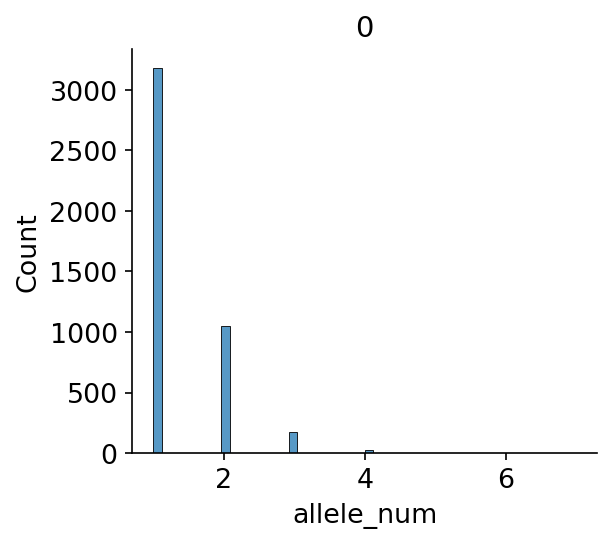

In [46]:
for j in range(len(df_assigned_clone_list)):
    fig,ax=plt.subplots(figsize=(4,3.5))
    sns.histplot(df_assigned_clone_list[j]['allele_num'],log_scale=False)
    plt.title(j)

<Axes: xlabel='allele_num', ylabel='Count'>

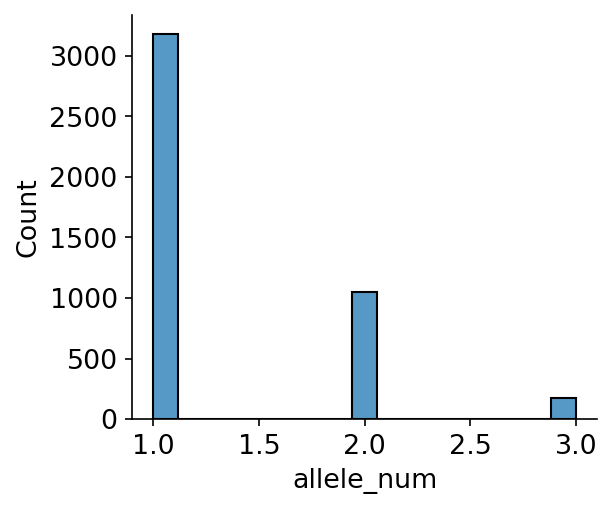

In [47]:
sns.histplot(df_assigned_clone_final['allele_num'],log_scale=False)

In [48]:
(df_sc_data_final['sample_count']==0).mean()

0.8492202048417132